In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.2 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.21.0-py_0

The following packages will be UPDATED:

  openssl                                 1.1.1f-h516909a_0 --> 1.1.1g-h516909a_0



openssl-1.1.1g       | 2.1 MB    | ############

In [162]:
df = pd.read_csv("Districts.csv")
df.head()

,Neighborhood,Latitude,Longitude
0,ZRHd1_1,47.373055,8.538622
1,ZRHd1_2,47.371060,8.546883
2,ZRHd2_1,47.362536,8.531325
3,ZRHd2_2,47.355346,8.530505
4,ZRHd2_3,47.346413,8.528994


In [115]:
CLIENT_ID = 'R01UF0T214HOFLUALFCS4JRP44JNYL1EDV00JSDNVPRCKL1O' # your Foursquare ID
CLIENT_SECRET = 'CGUOYLE3OS10ZK0MV4KVCLASHJFPTBWRWEBP2NQD2IPR0N3C' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: R01UF0T214HOFLUALFCS4JRP44JNYL1EDV00JSDNVPRCKL1O
CLIENT_SECRET:CGUOYLE3OS10ZK0MV4KVCLASHJFPTBWRWEBP2NQD2IPR0N3C


In [116]:
address = 'Zurich'

geolocator = Nominatim(user_agent="ZRH_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_districts = folium.Map(location=[latitude, longitude], zoom_start=3)

for lat, lng, neighborhood in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = neighborhood
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_districts)  
    
map_districts

In [117]:
#this makes a function to get all the venues for each neighborhood
def getNearbyVenues(names, latitudes, longitudes, radius=800, LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try :
            results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
            print(name, 'BROKE')
            pass

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [118]:
Districts_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

ZRHd1_1
ZRHd1_2
ZRHd2_1
ZRHd2_2
ZRHd2_3
ZRHd2_4
ZRHd3_1
ZRHd3_2
ZRHd3_3
ZRHd3_4
ZRHd4_1
ZRHd4_2
ZRHd5_1
ZRHd5_2
ZRHd5_3
ZRHd6_1
ZRHd6_2
ZRHd6_3
ZRHd6_4
ZRHd6_5
ZRHd7_1
ZRHd7_2
ZRHd7_3
ZRHd7_4
ZRHd8_1
ZRHd8_2
ZRHd8_3
ZRHd8_4
ZRHd9_1
ZRHd9_2
ZRHd9_3
ZRHd9_4
ZRHd9_5
ZRHd10_1
ZRHd10_2
ZRHd10_3
ZRHd10_4
ZRHd10_5
ZRHd11_1
ZRHd11_2
ZRHd11_3
ZRHd11_4
ZRHd11_5
ZRHd12_1
Zollikon
Kusnacht
Kilchberg
Ruschlikon
South Ken
Greenwich
West Loop


In [163]:
print(Districts_venues.shape)
print('There are {} uniques categories.'.format(len(Districts_venues['Venue Category'].unique())))
Districts_venues.head()

(2679, 7)
There are 250 uniques categories.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,ZRHd1_1,47.373055,8.538622,Lindenhof,47.373005,8.540883,Pedestrian Plaza
1,ZRHd1_1,47.373055,8.538622,Widder Bar,47.372415,8.539863,Hotel Bar
2,ZRHd1_1,47.373055,8.538622,Old Crow,47.372092,8.541024,Cocktail Bar
3,ZRHd1_1,47.373055,8.538622,Bahnhofstrasse,47.374699,8.538872,Pedestrian Plaza
4,ZRHd1_1,47.373055,8.538622,Widder Hotel,47.372449,8.539973,Hotel


In [164]:
# one hot encoding
Districts_onehot = pd.get_dummies(Districts_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Districts_onehot['Neighborhood'] = Districts_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Districts_onehot.columns[-1]] + list(Districts_onehot.columns[:-1])
Districts_onehot = Districts_onehot[fixed_columns]

Districts_grouped = Districts_onehot.groupby('Neighborhood').mean().reset_index()

In [165]:
#this is a function that sorsts the venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [166]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
districts_venues_sorted = pd.DataFrame(columns=columns)
districts_venues_sorted['Neighborhood'] = Districts_grouped['Neighborhood']

for ind in np.arange(Districts_grouped.shape[0]):
    districts_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Districts_grouped.iloc[ind, :], num_top_venues)

In [167]:
# elbow method to find best k for Kmeans
Sum_of_squared_distances = []
Districts_grouped_clustering = Districts_grouped.drop('Neighborhood', 1)
K = range(1,48)
for k in K:
    km = KMeans(n_clusters=k, random_state=1)
    km = km.fit(Districts_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

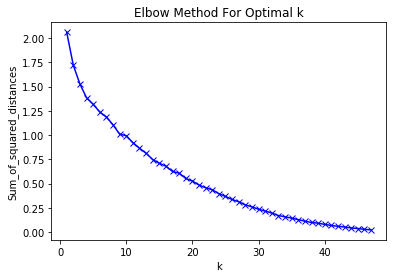

In [168]:
#ploting the elbow method
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [169]:
#based on the elbow method, a k=22 was selected to be used in the K-means clustering 
k = 22

kmeans = KMeans(n_clusters=k, random_state=1).fit(Districts_grouped_clustering)

In [170]:
# add clustering labels
districts_venues_sorted.insert(0, 'ClusterLabel', kmeans.labels_)

Districts_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Districts_merged = Districts_merged.join(districts_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Districts_merged

,Neighborhood,Latitude,Longitude,ClusterLabel,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,ZRHd1_1,47.373055,8.538622,11,Bar,Café,Swiss Restaurant,Vegetarian / Vegan Restaurant,Cocktail Bar
1,ZRHd1_2,47.371060,8.546883,11,Swiss Restaurant,Plaza,Café,Bar,Cocktail Bar
2,ZRHd2_1,47.362536,8.531325,17,Hotel,Park,Restaurant,Bar,Italian Restaurant
3,ZRHd2_2,47.355346,8.530505,12,Park,Italian Restaurant,Restaurant,Tram Station,Light Rail Station
4,ZRHd2_3,47.346413,8.528994,16,Park,Supermarket,Bus Station,Restaurant,Train Station
5,ZRHd2_4,47.338398,8.531827,8,Bus Station,Restaurant,Harbor / Marina,Supermarket,Pizza Place
6,ZRHd3_1,47.369357,8.519093,0,Café,Italian Restaurant,Bar,Thai Restaurant,Pizza Place
7,ZRHd3_2,47.362975,8.517507,17,Italian Restaurant,Restaurant,Hotel,Supermarket,Swiss Restaurant
8,ZRHd3_3,47.367453,8.506836,21,Supermarket,Bus Station,Tram Station,Pizza Place,Plaza
9,ZRHd3_4,47.374435,8.509835,0,Café,Bar,Italian Restaurant,Supermarket,Pizza Place


In [ ]:
#map all the neighborhoods and color them by the k-means clustering. 
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

In [220]:
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Districts_merged['Latitude'], Districts_merged['Longitude'], Districts_merged['Neighborhood'], Districts_merged['ClusterLabel']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    if (cluster == Districts_merged.loc[50, 'ClusterLabel']):
        folium.polygon_marker(
            [lat, lon],
            radius=5,
            num_sides=3,
            popup=label,
            color='#000000',
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)
    if (cluster == Districts_merged.loc[48, 'ClusterLabel']):
        folium.polygon_marker(
            [lat, lon],
            radius=5,
            num_sides=4,
            popup=label,
            color='#000000',
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)
    if ((cluster != 11) & (cluster != 12)):
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)
    
    
#legend of the map
legend_html =   '''
                <div style="position: fixed; 
                            top: 50px; right: 40px; width: 300px; height: 160px; 
                            background-color:#ffffff; z-index:9999; font-size:20px font-weight:bold;
                            ">&nbsp; <span style="font-size:25px; color:#000000"> Legend </span><br><br>
                              &nbsp;Similar areas clustered under the same color&nbsp; <br><br>
                              &nbsp;<span style="color:#777777; font-weight:bold">Circled </span>area similar to West Ken,  London &nbsp; <br>
                              &nbsp;<span style="color:#000000; font-weight:bold">Circled </span>area similar to West Loop, Chicago &nbsp; <br>
                              &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;   & Greenwich, NY &nbsp;
                </div>
                ''' 
map_clusters.get_root().html.add_child(folium.Element(legend_html))   

map_clusters

In [221]:
map_clusters.save('ZRH_map.html')